# 다층 퍼셉트론으로 텍스트 분류

## 다층 퍼셉트론( MultiLayer Perceptron, MLP )

- 단층 퍼셉트론의 형태에서 은닉층이 1개 이상 추가된 신경망
- 다층 퍼셉트론은 피드 포워드 신경망( Feed Forward Neural Network, FFNN )의 가장 기본적인 형태
- 피드 포워드 신경망( FFNN )은 입력층에서 출력층으로 오직 한 방향으로만 연산 방향이 정해져 있는 신경망

---



In [2]:
!pip list

Package                  Version        
------------------------ ---------------
absl-py                  0.9.0          
alabaster                0.7.12         
albumentations           0.1.12         
altair                   4.1.0          
asgiref                  3.2.10         
astor                    0.8.1          
astropy                  4.0.1.post1    
astunparse               1.6.3          
atari-py                 0.2.6          
atomicwrites             1.4.0          
attrs                    19.3.0         
audioread                2.1.8          
autograd                 1.3            
Babel                    2.8.0          
backcall                 0.2.0          
beautifulsoup4           4.6.3          
bleach                   3.1.5          
blis                     0.4.1          
bokeh                    1.4.0          
boto                     2.49.0         
boto3                    1.14.20        
botocore                 1.17.20        
Bottleneck      

In [3]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_20newsgroups # 20개 뉴스그룹 데이터 셋

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical

## 1. 20개 뉴스 그룹 데이터 이해

In [4]:
newsdata = fetch_20newsgroups( subset = 'train' ) # 훈련 데이터만 리턴

In [5]:
print( newsdata.keys() )

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])


In [6]:
print( '훈련용 샘플 개수 : {}'.format( len( newsdata.data ) ) )

훈련용 샘플 개수 : 11314


In [7]:
print( '총 주제의 개수 :{}'.format( len( newsdata.target_names ) ) )
print( newsdata.target_names )

총 주제의 개수 :20
['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


In [8]:
print( '첫번째 샘플의 레이블 : {}'.format( newsdata.target[ 0 ] ) )

첫번째 샘플의 레이블 : 7


In [10]:
print( '7번 레이블이 의미하는 주제 : {}'.format( newsdata.target_names[ 7 ] ) )

7번 레이블이 의미하는 주제 : rec.autos


In [11]:
print( newsdata.data[ 0 ] )

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----







## 2. DataFrame으로 변환 및 EDA

In [12]:
data = pd.DataFrame( newsdata.data, columns = [ 'email' ] )
data[ 'target' ] = pd.Series( newsdata.target )
data.head()

,email,target
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14


In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11314 entries, 0 to 11313
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   email   11314 non-null  object
 1   target  11314 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 176.9+ KB


In [14]:
data.isnull().values.any()

False

In [16]:
print( '중복을 제외한 샘플 수 : {}'.format( data[ 'email' ].nunique() ) )
print( '중복을 제외한 주제 수 : {}'.format( data[ 'target' ].nunique() ) )

중복을 제외한 샘플 수 : 11314
중복을 제외한 주제 수 : 20


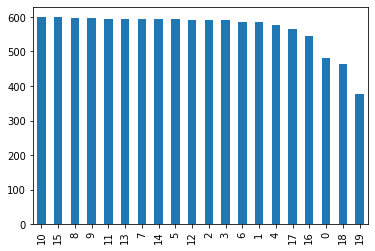

In [17]:
data[ 'target' ].value_counts().plot( kind = 'bar' )

In [18]:
print( data.groupby( 'target' ).size().reset_index( name = 'count' ) )

    target  count
0        0    480
1        1    584
2        2    591
3        3    590
4        4    578
5        5    593
6        6    585
7        7    594
8        8    598
9        9    597
10      10    600
11      11    595
12      12    591
13      13    594
14      14    593
15      15    599
16      16    546
17      17    564
18      18    465
19      19    377


In [19]:
# 데이터프레임의 메일 본문과 레이블 분리, 테스트 데이터 불러오기
newsdata_test = fetch_20newsgroups( subset = 'test', shuffle = True ) # 테스트data

train_email = data[ 'email' ] # 훈련 데이터 - 본문
train_label = data[ 'target' ] # 훈련 데이터 - 레이블

test_email = newsdata_test.data # 테스트 데이터 - 본문
test_label = newsdata_test.target # 테스트 데이터 - 레이블

## 3. 텍스트에 대한 전처리

In [20]:
max_words = 10000 # 단어 최대수
num_classes = 20 # 레이블의 수

In [21]:
# 텍스테에 대한 전처리 수행 사용자 정의 함수
def prepare_data( train_data, test_data, mode ):
  t = Tokenizer( num_words = max_words ) # max_words 단어만 사용하여 토큰화
  t.fit_on_texts( train_data ) # 단어 토큰화에 대한 정수 인코딩( Integer Encoding )

  # 문서 단어 행렬( Document-Term Matrix, DTM )
  # 샘플 수 * max_words 크기 행렬 생성
  X_train = t.texts_to_matrix( train_data, mode = mode ) 
  # 샘플 수 * max_words 크기 행렬 생성
  X_test = t.texts_to_matrix( test_data, mode = mode )

  return X_train, X_test, t.index_word

In [22]:
X_train, X_test, index_to_word = prepare_data( train_email, test_email, 'binary' )
y_train = to_categorical( train_label, num_classes )
y_test = to_categorical( test_label, num_classes )

In [23]:
print( '훈련 샘플 본문의 크기 :{}'.format( X_train.shape ) )
print( '훈련 샘플 레이블의 크기 : {}'.format( y_train.shape ) )
print( '테스트 샘플 본문의 크기 : {}'.format( X_test.shape ) )
print( '테스트 샘플 레이블의 크기 : {}'.format( y_test.shape ) )

훈련 샘플 본문의 크기 :(11314, 10000)
훈련 샘플 레이블의 크기 : (11314, 20)
테스트 샘플 본문의 크기 : (7532, 10000)
테스트 샘플 레이블의 크기 : (7532, 20)


In [24]:
print( '빈도수 상위 1번 단어 : {}'.format( index_to_word[ 1 ] ) )
print( '빈도수 상위 9999번 단어 : {}'.format( index_to_word[ 9999 ] ) )

빈도수 상위 1번 단어 : the
빈도수 상위 9999번 단어 : mic


## 4. MLP를 이용한 텍스트 분류

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [27]:
def fit_and_evaluate( X_train, y_train, X_test, y_test ):
  model = Sequential()
  model.add( Dense( 256, input_shape = ( max_words, ), activation = 'relu' ) )
  model.add( Dropout( 0.5 ) )
  model.add( Dense( 128, activation = 'relu' ) )
  model.add( Dropout( 0.5 ) )
  model.add( Dense( num_classes, activation = 'softmax' ) )

  model.compile( loss = 'categorical_crossentropy', optimizer = 'adam',
                 metrics = [ 'accuracy' ] )
  model.fit( X_train, y_train, batch_size = 128, epochs = 5, verbose = 1,
             validation_split = 0.1 )
  
  hist = model.evaluate( X_test, y_test, batch_size = 128, verbose = 0 )

  return hist[ 1 ]

In [29]:
X_train, X_test, _ = prepare_data( train_email, test_email, 'tfidf' )
score = fit_and_evaluate( X_train, y_train, X_test, y_test )
print( 'tfidf 모드의 테스트 정확도 : {}'.format( score ) )

Epoch 1/5
80/80 [==============================] - 4s 45ms/step - loss: 2.2045 - accuracy: 0.3678 - val_loss: 0.7700 - val_accuracy: 0.8401
Epoch 2/5
80/80 [==============================] - 3s 43ms/step - loss: 0.8430 - accuracy: 0.7742 - val_loss: 0.4239 - val_accuracy: 0.8940
Epoch 3/5
80/80 [==============================] - 3s 43ms/step - loss: 0.4692 - accuracy: 0.8751 - val_loss: 0.3657 - val_accuracy: 0.9019
Epoch 4/5
80/80 [==============================] - 3s 43ms/step - loss: 0.3100 - accuracy: 0.9240 - val_loss: 0.3333 - val_accuracy: 0.9002
Epoch 5/5
80/80 [==============================] - 3s 43ms/step - loss: 0.2028 - accuracy: 0.9497 - val_loss: 0.3222 - val_accuracy: 0.9117
tfidf 모드의 테스트 정확도 : 0.8321827054023743
